In [2]:
import numpy as np
import pandas as pd
import librosa as lr
import os
import json
import scipy.io.wavfile as wav
from scipy.fftpack import dct
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
import random
from datetime import datetime

from sklearn import metrics
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Define the GFCC Extractor

In [3]:
dataset='./dataset/'
pd.DataFrame(os.listdir(dataset),columns=['Files'])

,Files
0,backward
1,go
2,left
3,right
4,stop


In [4]:
def count(path):
    size=[]
    for file in os.listdir(path):
        size.append(len(os.listdir(os.path.join(path,file))))
    return pd.DataFrame(size,columns=['Number Of Sample'],index=os.listdir(path))  
tr=count(dataset)
tr

,Number Of Sample
backward,1664
go,2372
left,2353
right,2367
stop,2380


In [5]:
def load(path):
    data=[]
    label=[]
    sample=[]
    for file in os.listdir(path):
        path_=os.path.join(path,file)
        for fil in os.listdir(path_):
            data_contain,sample_rate=lr.load(os.path.join(path_,fil) ,sr=16000)
            data.append(data_contain)
            sample.append(sample_rate)
            label.append(file)
    return data,label,sample

data,label,sample=load(dataset)
df=pd.DataFrame()
df['Label'],df['sample']=label,sample
df

,Label,sample
0,backward,16000
1,backward,16000
2,backward,16000
3,backward,16000
4,backward,16000
...,...,...
11131,stop,16000
11132,stop,16000
11133,stop,16000
11134,stop,16000


In [6]:
def erb_bandwidth(f):
    return 24.7 * (4.37e-3 * f + 1.0)

def gammatone_filter(f, f_center, sr, NFFT):
    t = np.linspace(0, 1, sr)[:NFFT // 2 + 1]
    gamma_tone = np.power(t, 3) * np.exp(-2 * np.pi * erb_bandwidth(f_center) * t) * np.cos(2 * np.pi * f * t)
    return np.abs(np.fft.rfft(gamma_tone, NFFT)[:NFFT // 2 + 1])

def make_gammatone_filterbank(nfilt, NFFT, sr):
    fmin = 20
    fmax = sr / 2
    fcenter = np.geomspace(fmin, fmax, nfilt)
    gt_filters = np.zeros((nfilt, NFFT // 2 + 1))
    for i in range(nfilt):
        gt_filters[i] = gammatone_filter(fcenter[i], fcenter[i], sr, NFFT)
    return gt_filters

def extract_gfcc(audio_file, n_gfcc=13):
    # Load the audio file using scipy
    sr, y = wav.read(audio_file)

    # Pre-emphasis
    pre_emphasis = 0.97
    emphasized_signal = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

    # Framing
    frame_size = 0.025
    frame_stride = 0.01
    frame_length, frame_step = frame_size * sr, frame_stride * sr
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(
        np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # Windowing
    frames *= np.hamming(frame_length)

    # Fourier Transform and Power Spectrum
    NFFT = 512
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Gammatone Filter Bank
    nfilt = 40
    gt_filters = make_gammatone_filterbank(nfilt, NFFT, sr)
    filter_banks = np.dot(pow_frames, gt_filters.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)

    # DCT to get GFCC
    gfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1: (n_gfcc + 1)]

    return gfcc

Extract features with GFCC and Save to JSON

In [7]:
# Dictionary to store GFCC features for each audio file
features = []
labels = []
gfcc_features = {}

# Mapping of conditions to labels
unique_conditions = ['go', 'stop', 'right', 'left', "backward"]
condition_to_label = {condition: index for index, condition in enumerate(unique_conditions)}

# Iterate over subdirectories and files in the base directory
for root, dirs, files in os.walk(dataset):
    for file in files:
        if file.endswith(".wav"):
            full_path = os.path.join(root, file)
            gfcc = extract_gfcc(full_path)
            # Extract label based on subfolder name (use root, not dirs)
            condition = os.path.basename(root)
            label = condition_to_label.get(condition, len(unique_conditions))
            features.append(gfcc)
            labels.append(label)
            gfcc_features[file] = gfcc

# Pad the GFCC sequences to have a consistent length
X = sequence.pad_sequences(features, padding='post', dtype='float32')  # Updated import

# Convert lists to NumPy arrays
y = np.array(labels)
unique_elements, counts_elements = np.unique(labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

print(X.shape)
print(y.shape)

[[   0    1    2    3    4]
 [2372 2380 2367 2353 1664]]
(11136, 98, 13)
(11136,)


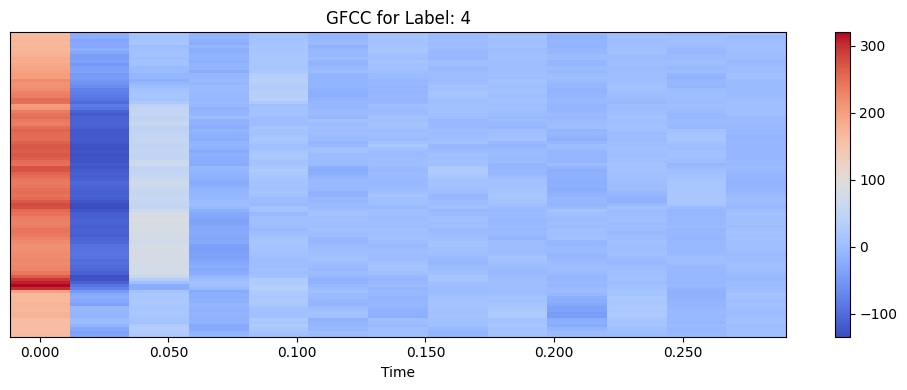

In [8]:
plt.figure(figsize=(10, 4))
lr.display.specshow(features[600], x_axis='time')
plt.colorbar()
plt.title('GFCC for Label: {}'.format(labels[600]))
plt.tight_layout()
plt.show()

In [9]:
# Save the NumPy arrays to a JSON file
json_data = {"features": X.tolist(), "labels": y.tolist()}
json_file_path = "gfcc_data.json"
with open(json_file_path, 'w') as json_file:
    json.dump(json_data, json_file)

Define all the needs for Training

In [10]:
DATA_PATH = "./gfcc_data.json"
EPOCHS = 50
BATCH_SIZE = 16
PATIENCE = 9
LEARNING_RATE = 0.0001
test_size = 0.1
validation_size = 0.22

Load the JSON file

In [11]:
# Load the JSON file
json_file_path = "gfcc_data.json"
with open(json_file_path, 'r') as json_file:
    data = json.load(json_file)

X = np.array(data["features"])
y = np.array(data["labels"])
y = to_categorical(y, num_classes=5)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print(y)

Shape of X: (11136, 98, 13)
Shape of y: (11136, 5)
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


Splitting the Data

In [12]:
# create train, validation, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=40)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, shuffle=True, random_state=42, stratify=y_train)


print("Jumlah data training :", round(len(X_train)/len(X)*100), "%")
print("Jumlah data test :", round(len(X_test)/len(X)*100), "%")
print("Jumlah data validation :", round(len(X_validation)/len(X)*100), "%\n")

Jumlah data training : 70 %
Jumlah data test : 10 %
Jumlah data validation : 20 %



Define the ANN Model

In [19]:
input_shape = (X_train.shape[1], X_train.shape[2])
print(input_shape)
    # build network architecture layers
model = tf.keras.Sequential([
    # input layer
    tf.keras.layers.Flatten(input_shape=input_shape),
    # 1st dense layer
    tf.keras.layers.Dense(512, activation='relu'),
    # 2nd dense layer
    tf.keras.layers.Dense(256, activation='relu'),
    # 3rd dense layer
    tf.keras.layers.Dense(128, activation='relu'),
    # 4rd dense layer
    tf.keras.layers.Dense(64, activation='relu'),
    # 5rd dense layer
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    # Output layer
    tf.keras.layers.Dense(5, activation='softmax')
    ])

# compile model
model.compile(optimizer="adam",
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

(98, 13)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1274)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               652800    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)      

Train the Model

In [14]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.01, patience=PATIENCE)
start = datetime.now()
# train model
history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_validation, y_validation),
                    callbacks=[earlystop_callback],
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50
489/489 [==============================] - 7s 9ms/step - loss: 2.1746 - accuracy: 0.3125 - val_loss: 1.3952 - val_accuracy: 0.3256
Epoch 2/50
489/489 [==============================] - 4s 9ms/step - loss: 1.4769 - accuracy: 0.3089 - val_loss: 1.3513 - val_accuracy: 0.4086
Epoch 3/50
489/489 [==============================] - 4s 8ms/step - loss: 1.4164 - accuracy: 0.3460 - val_loss: 1.3122 - val_accuracy: 0.4054
Epoch 4/50
489/489 [==============================] - 4s 8ms/step - loss: 1.3432 - accuracy: 0.3962 - val_loss: 1.3154 - val_accuracy: 0.3837
Epoch 5/50
489/489 [==============================] - 4s 9ms/step - loss: 1.3427 - accuracy: 0.4085 - val_loss: 1.2715 - val_accuracy: 0.4499
Epoch 6/50
489/489 [==============================] - 4s 9ms/step - loss: 1.2062 - accuracy: 0.4445 - val_loss: 1.0822 - val_accuracy: 0.5011
Epoch 7/50
489/489 [==============================] - 4s 8ms/step - loss: 1.1359 - accuracy: 0.4564 - val_loss: 1.1257 - val_accuracy: 0.5624
Epoch 

Plot the Learning Curve

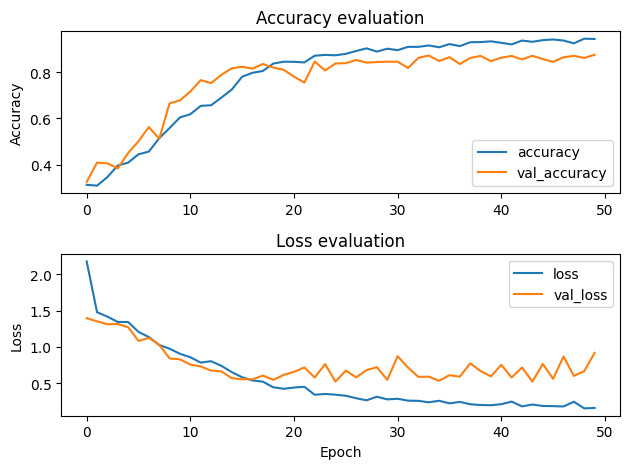

In [15]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    fig.tight_layout()
    plt.show()
    
plot_history(history)

In [16]:
def predict(model, X, y):

    X = X[np.newaxis, ...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)

    print("Data Asli: {}, Hasil Prediksi: {}".format(y, predicted_index))

In [17]:
def confusionMatrix(model, X_test, y_test):

  pred = model.predict(X_test)
  y_pred = []
  for i in pred:
      y_pred.append(np.argmax(i))

  # Ensure y_test_one_hot is used instead of y_test
  conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

  # Specify the correct display labels for all classes in your dataset
  display_labels = ['go', 'stop', 'right', 'left', "backward"]

  # Visualize the confusion matrix
  cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels)
  cm_display.plot()
  cm_display.ax_.set_title("Confusion Matrix")
  plt.show()

  # Convert y_test_one_hot to class labels
  y_test_labels = np.argmax(y_test, axis=1)
  
  # Calculate accuracy using class labels
  accuracy = accuracy_score(y_test_labels, y_pred)
  
  # Calculate recall using class labels
  recall = recall_score(y_test_labels, y_pred, average='weighted')
  # Calculate precision using class labels
  precision = precision_score(y_test_labels, y_pred, average='weighted')
  F1 = f1_score(y_test_labels, y_pred, average='weighted')

  print("Accuracy :", accuracy*100, " %")
  print("Recall :", recall*100, " %")
  print("Precision :", precision*100, " %")
  print("F1-Score :", F1*100, " %")

 1/35 [..............................] - ETA: 1s - loss: 0.6943 - accuracy: 0.9375

35/35 [==============================] - 0s 7ms/step - loss: 0.8440 - accuracy: 0.8636

Test loss: 0.8439689874649048, 
Test accuracy: 86.35547757148743
1/1 [==============================] - 0s 164ms/step
Data Asli: [0. 0. 1. 0. 0.], Hasil Prediksi: [2]
1/1 [==============================] - 0s 33ms/step
Data Asli: [0. 0. 0. 1. 0.], Hasil Prediksi: [3]
1/1 [==============================] - 0s 28ms/step
Data Asli: [1. 0. 0. 0. 0.], Hasil Prediksi: [0]
1/1 [==============================] - 0s 31ms/step
Data Asli: [0. 0. 1. 0. 0.], Hasil Prediksi: [2]
1/1 [==============================] - 0s 29ms/step
Data Asli: [0. 0. 1. 0. 0.], Hasil Prediksi: [2]
1/1 [==============================] - 0s 26ms/step
Data Asli: [0. 1. 0. 0. 0.], Hasil Prediksi: [1]
1/1 [==============================] - 0s 30ms/step
Data Asli: [0. 0. 1. 0. 0.], Hasil Prediksi: [2]
1/1 [==============================] - 0s 32ms/step
Data Asli: [0. 0. 1. 0. 0.], Hasil Prediksi: [2]
1/1 [==============================] -

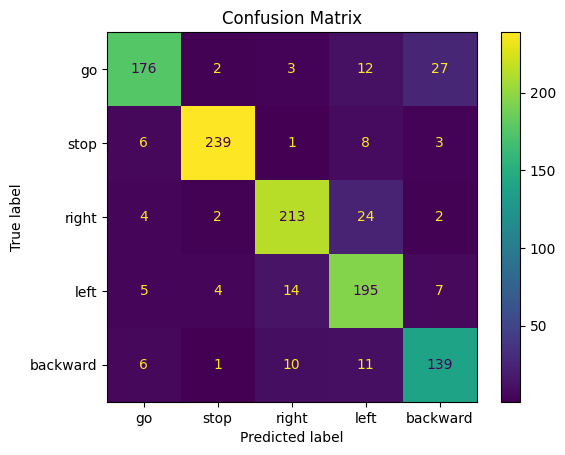

Accuracy : 86.35547576301616  %
Recall : 86.35547576301616  %
Precision : 86.77441584525334  %
F1-Score : 86.44747616341087  %


In [18]:
# evaluate network on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, \nTest accuracy: {}".format(test_loss, 100*test_acc))

# Uji Prediksi
for _ in range(50):
    r = random.randint(0,len(X_test)-1)
    X_to_predict = X_test[r]
    y_to_predict = y_test[r]

    predict(model, X_to_predict, y_to_predict)
#Visualisasikan hasil Prediksi dan Akurasi
confusionMatrix(model, X_test, y_test)